In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os, sys, math
import numpy as np
#import pandas as pd
import sklearn as skl
import statistics
from sklearn.neighbors import NearestNeighbors, DistanceMetric
#from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
import scipy.special as sp
#
import emcee
import corner 
import time
#
from __future__ import print_function
import IPython
#
import eknn
%matplotlib inline

## Wrapper to getdist 

In [47]:
from getdist import plots, MCSamples
import getdist as gd
class samples2gdist(object):
    #Ref:
    #http://getdist.readthedocs.io/en/latest/plot_gallery.html
    
    def __init__(self,chain,lnprob,
                names=None,labels=None):
        #Get the getdist MCSamples objects for the samples, specifying same parameter
        #names and labels; if not specified weights are assumed to all be unity
        
        ndim=chain.shape[-1]
        
        if names is None:
            names = ["x%s"%i for i in range(ndim)]
        if labels is None:
            labels =  ["x_%s"%i for i in range(ndim)]
            

        self.samples = gd.MCSamples(samples=chain,loglikes=lnprob,
                             names = names, labels = labels)
            
    def triangle(self,**kwargs):
        #Triangle plot
        g = gd.plots.getSubplotPlotter()
        g.triangle_plot(self.samples, filled=True,**kwargs)
        
    def plot_1d(self,l,**kwargs):
        #1D marginalized plot
        g = gd.plots.getSinglePlotter(width_inch=4)        
        g.plot_1d(self.samples, l,**kwargs)
        
    def plot_2d(self,l,**kwargs):
        #Customized 2D filled comparison plot
        g = gd.plots.getSinglePlotter(width_inch=6, ratio=3 / 5.)       
        g.plot_1d(self.samples, l,**kwargs)      
        
    def plot_3d(self,llist):
        #2D scatter (3D) plot
        g = gd.plots.getSinglePlotter(width_inch=5)
        g.plot_3d(self.samples, llist)   
        
    def save_to_file(self,path=None,dname='chain',froot='test'):
        #Save to file
        import tempfile, os
        if path is None:
            path=tempfile.gettempdir()
        tempdir = os.path.join(path,dname)
        if not os.path.exists(tempdir): os.makedirs(tempdir)
        rootname = os.path.join(tempdir, froot)
        self.samples.saveAsText(rootname)     
        
    def load_from_file(rootname):
        #Load from file
        self.samples=[]
        for f in rootname:
            self.samples.append(gd.loadMCSamples(rootname))
            
    def info(self): 
        #these are just to show getdist functionalities
        print(self.samples.PCA(['x1','x2']))
        print(self.samples.getTable().tableTex())
        print(self.samples.getInlineLatex('x1',limit=1))

## PyStan example

In [27]:
import pystan

mvgauss_code="""
data {
  int<lower=1> N;
  vector[N] s;
  vector[N] y;
}
parameters {
  vector[N] mu; 
}
transformed parameters {  
  cov_matrix[N] Sigma;
  for (i in 1:N) 
    for (j in 1:N)
      Sigma[i,j] <- 0 + if_else(i==j, s[i], 0.0);
}
model {
  y ~ multi_normal(mu,Sigma);
}
"""


fit = pystan.stan(model_code=mvgauss_code, data=mvgauss_dat,
                  iter=1000, chains=4)


In [28]:
#fit.traceplot('mu')
chain=fit.extract('mu', permuted=True)
chain['mu'].shape

(2000, 10)

## Emcee example

In [45]:
##learn about emcee sampler using help
#help(mec2d.sampler)

In [56]:
#sampling 
class make_emcee_chain(object):
    # A wrapper to the emcee MCMC sampler
    #
    def __init__(self,model,nwalkers=500,nburn=300,arg={}):
        
        #check if model is string or not
        if isinstance(model,str):
            print('name of model: ',model)
            XClass = getattr(sys.modules[__name__], model)
        else:            
            XClass=model        
            
        #check if XClass is instance or not
        if hasattr(XClass, '__class__'): 
            print('instance of a model class is passed')
            self.model=XClass #it is instance 
        else:
            print('class variable is passed .. instantiating class')
            self.model=XClass(*arg)
          
        self.ndim=self.model.ndim
        
        #init emcee sampler
        self.nwalkers=nwalkers
        self.emcee_sampler = emcee.EnsembleSampler(self.nwalkers, 
                                             self.model.ndim, 
                                             self.model.lnprob)   
        
        # burnin phase
        pos0=self.model.pos(self.nwalkers)
        pos, prob, state  = self.emcee_sampler.run_mcmc(pos0, nburn)
        
        #save emcee state
        self.prob=prob
        self.pos=pos
        self.state=state
        
        #discard burnin chain 
        self.samples = self.emcee_sampler.flatchain        
        self.emcee_sampler.reset()
        
    def Sampler(self,nsamples=2000):
        # perform MCMC
        time0 = time.time()
        N=np.ceil(np.float(nsamples)/np.float(self.nwalkers))
        #
        #pos=None makes the chain start from previous state of sampler
        self.pos, self.prob, self.state  = self.emcee_sampler.run_mcmc(self.pos,N)
        self.samples = self.emcee_sampler.flatchain    
        self.lnp = self.emcee_sampler.flatlnprobability
        self.emcee_sampler.reset()
        #
        time1=time.time()
        #
        print('emcee total time spent: ',time1-time0)        
        print('samples shape: ',self.samples.shape)  
        
        return self.samples,self.lnp

    def vis(self,chain=None,figsize=(10,10),**kwargs):
        # Visualize the chains

        if chain is None:
            chain=self.samples

        fig = corner.corner(chain, labels=self.model.label, 
                                   truths=self.model.p,
                                   **kwargs)            

        fig.set_size_inches(figsize)  
            
    def info(self):
        print("Example using emcee sampling") 
        print('nwalkers=',self.walkers)
        try:
            self.model.info()
        except:
            pass
        print()        

In [5]:
# Define the posterior PDF
# Reminder: post_pdf(theta, data) = likelihood(data, theta) * prior_pdf(theta)
# We take the logarithm since emcee needs it.
#---------------    
class model_2d(object):
    def __init__(self,p=[-0.9594,4.294],pprior=None,
                 N=50,x=None,**kwargs):
    
        f=lambda t,s: np.array([t-s*abs(t),t+s*abs(t)])
        
        if pprior is None:
            self.pprior={'p'+str(i) : f(t,10) for i,t in enumerate(p) }
            
        self.label=self.pprior.keys()
        self.ndim=len(p)
        self.p=p        
        if x is None:
            self.N=N
            self.x = np.sort(10*np.random.rand(N))
        else:
            self.N=len(x)
            self.x=x
            
        self.y,self.yerr=self.data(**kwargs)
        
    # As prior, we assume an 'uniform' prior (i.e. constant prob. density)
    def inprior(self,t,i):
        prange=self.pprior[self.label[i]]
        if  prange[0] < t < prange[1]:
            return 1.0
        else:
            return 0.0

    def lnprior(self,theta):
        for i,t in enumerate(theta):
            if self.inprior(t,i)==1.0:
                pass
            else:
                return -np.inf
        return 0.0
        

    # As likelihood, we assume the chi-square. 
    def lnlike(self,theta):
        m, b = theta
        model = m * self.x + b
        return -0.5*(np.sum( ((self.y-model)/self.yerr)**2. ))

    def lnprob(self,theta):
        lp = self.lnprior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.lnlike(theta)

    def data(self,sigma=0.5,aerr=0.2):
        # Generate synthetic data from a model.
        # For simplicity, let us assume a LINEAR model y = m*x + b
        # where we want to fit m and b      
        yerr = aerr + sigma*np.random.rand(self.N)
        y = self.p[0]*self.x + self.p[1]
        y += sigma * np.random.randn(self.N) 
        return y,yerr
    
    def pos(self,nwalkers):
        # uniform sample over prior space
        # will be used as starting place for
        # emcee sampler
        r=np.random.rand(nwalkers,self.ndim)
        pos=r
        for i,k in enumerate(self.pprior):
            prange=self.pprior[k]            
            psize = prange.max() - prange.min()
            pos[:,i]=prange.min()+psize*r[:,i]
        return pos
    
    def vis(self,n=300,figsize=(10,10),**kwargs):
        # Visualize the chains

        fig = corner.corner(self.pos(n), 
                            labels=self.label, 
                            truths=self.p,**kwargs)            
        fig.set_size_inches(figsize)     
        

instance of a model class is passed
('emcee total time spent: ', 2.879175901412964)
('samples shape: ', (50000, 2))
(50000,)
(50000, 2)


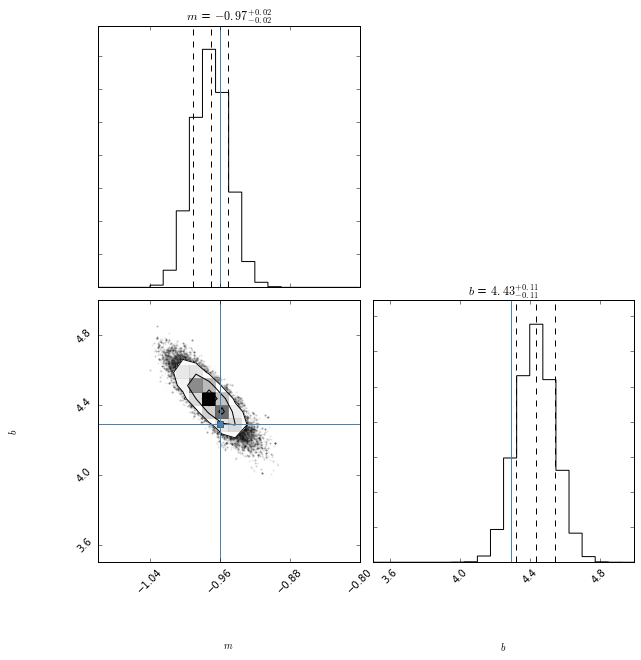

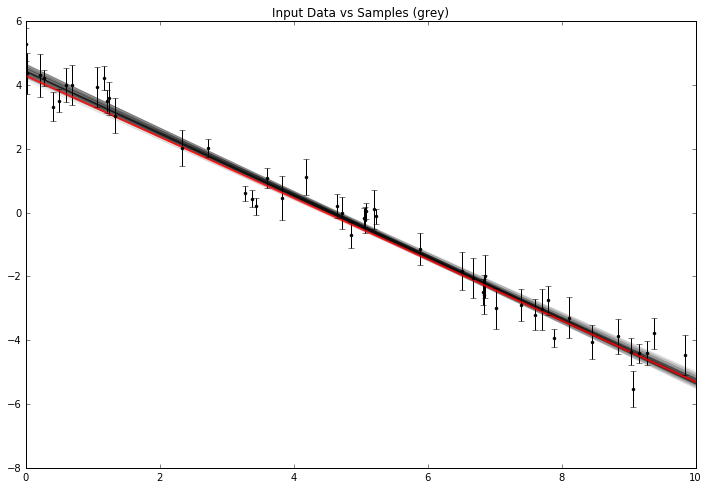

In [6]:
#test model class .. visualise uniform sampling
m2d=model_2d()

#test emcee wrapper 
mec2d=make_emcee_chain(m2d,nwalkers=200)
chain2d,fs=mec2d.Sampler(nsamples=50000)
print(fs.shape)
print(chain2d.shape)


#let's trangle plot chain samples 
fig = corner.corner(chain2d, labels=["$m$", "$b$"], extents=[[-1.1, -0.8], [3.5, 5.]],
                      truths=m2d.p, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, labels_args={"fontsize": 40})
fig.set_size_inches(10,10)

# Plot back the results in the space of data
fig = plt.figure()
xl = np.array([0, 10])
for m, b in chain2d[np.random.randint(len(chain2d), size=100)]:
    if m<0:
        plt.plot(xl, m*xl+b, color="k", alpha=0.1)
    
plt.plot(xl, m2d.p[0]*xl+m2d.p[1], color="r", lw=2, alpha=0.8)
plt.errorbar(m2d.x, m2d.y, yerr=m2d.yerr, fmt=".k")
plt.title('Input Data vs Samples (grey)')
fig.set_size_inches(12, 8)

## emcee sampling using N-dimensional Gaussian likelihood

In [58]:
#Evidence calculation based on emcee sampling
#mecNd=make_emcee_chain(mNd,nwalkers=200)
#ealan=eknn.echain(method=mecNd,verbose=2)
MLE=ealan.chains2evidence() 

('emcee total time spent: ', 0.08110713958740234)
('samples shape: ', (2000, 10))
(iter,mean,min,max) of LogLikelihood:  0 43.436428024 32.3161927804 47.7992919586
-------------------- useful intermediate parameter values ------- 
iter, nsample, dotp, median volume, amax, MLE
0 2000 4 0.455537956312 1.23859379041e-27 5.6935127648e-05 0.113870255296
('emcee total time spent: ', 0.05260515213012695)
('samples shape: ', (2000, 10))
1 2000 4 0.494888029964 9.34780643931e-28 6.18532720865e-05 0.123706544173
('emcee total time spent: ', 0.06522393226623535)
('samples shape: ', (2000, 10))
2 2000 4 0.495742371156 1.25773340537e-27 6.19600513881e-05 0.123920102776
('emcee total time spent: ', 0.07396388053894043)
('samples shape: ', (2000, 10))
3 2000 4 0.497978885491 3.00167614899e-27 6.22395807388e-05 0.124479161478
('emcee total time spent: ', 0.07547211647033691)
('samples shape: ', (2000, 10))
4 2000 4 0.645158542513 3.63674251578e-27 8.06347384719e-05 0.161269476944
('emcee total time sp

/Users/yabebal/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


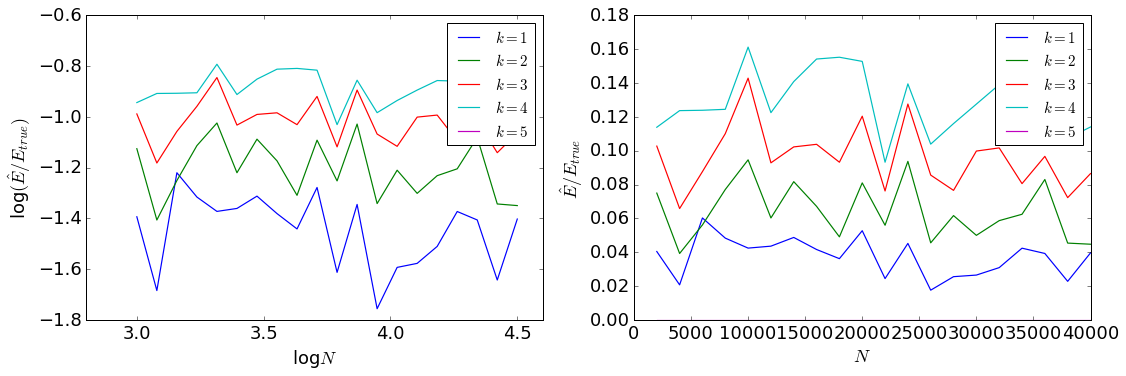

In [82]:
left    = None  # the left side of the subplots of the figure
right   = None  # the right side of the subplots of the figure
bottom  = None  # the bottom of the subplots of the figure
top     = None  # the top of the subplots of the figure
wspace  = 0.3   # the amount of width reserved for blank space between subplots
hspace  = 0.2   # the amount of height reserved for white space between subplots
fontSize=18

ytit='\dfrac{\hat{E}}{E_{\\textrm{true}}}'


fig,ax=plt.subplots(figsize=(18,12))
plt.subplot(2,2,1)
for k in range(1,ealan.kmax+1):
    plt.plot(ealan.powers,np.log10(MLE[:,k]), lw = 1.2, label = '$k=%s$'%k)
plt.xlabel('log$N$', fontsize = fontsize)
plt.ylabel('log$(\hat{E}/E_{true})$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc=1,prop={'size':15})

plt.subplot(2,2,2)
for k in range(1,ealan.kmax+1):
    plt.plot(ealan.nchain.cumsum(),MLE[:,k], lw = 1.2, label='$k=%s$'%k)
plt.xlabel('$N$', fontsize = fontSize)
plt.ylabel('$\hat{E}/E_{true}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc=1,prop={'size':15})

In [ ]:
plt.subplot(2,2,3)
for k in range(1,ealan.kmax+1):
    plt.plot(1/nchain,mle[:,k], lw = 1.2, label = '$k=%s$'%k)
plt.xlabel('$\\frac{1}{N}$', fontsize = fontSize)
plt.ylabel('$%s$'%ytit, fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc=2,prop={'size':15})

plt.subplot(2,2,4)
for k in range(1,ealan.kmax+1):
    plt.plot(pow(nchain,-1.0/ndim),mle[:,k], lw = 1.2, label='$k=%s$'%k)
plt.xlabel('$\dfrac{1}{N^{\\frac{1}{d}}}$', fontsize = fontSize)
plt.ylabel('$%s$'%ytit, fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc=2,prop={'size':15})

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

plt.show()


mean_sample= [ 1.00144627  2.0021568   3.00283947  3.99977335  5.00147185  5.99716131
  6.9974838   8.0005266   8.9984353   9.99859964]
std_sample= [ 1.00016902  0.99836941  1.00171257  0.99467714  0.99772978  0.99608858
  0.99725579  0.99978229  1.00304899  1.00132736]

instance of a model class is passed
('emcee total time spent: ', 1.2562849521636963)
('samples shape: ', (50000, 10))
(50000,)
(50000, 10)


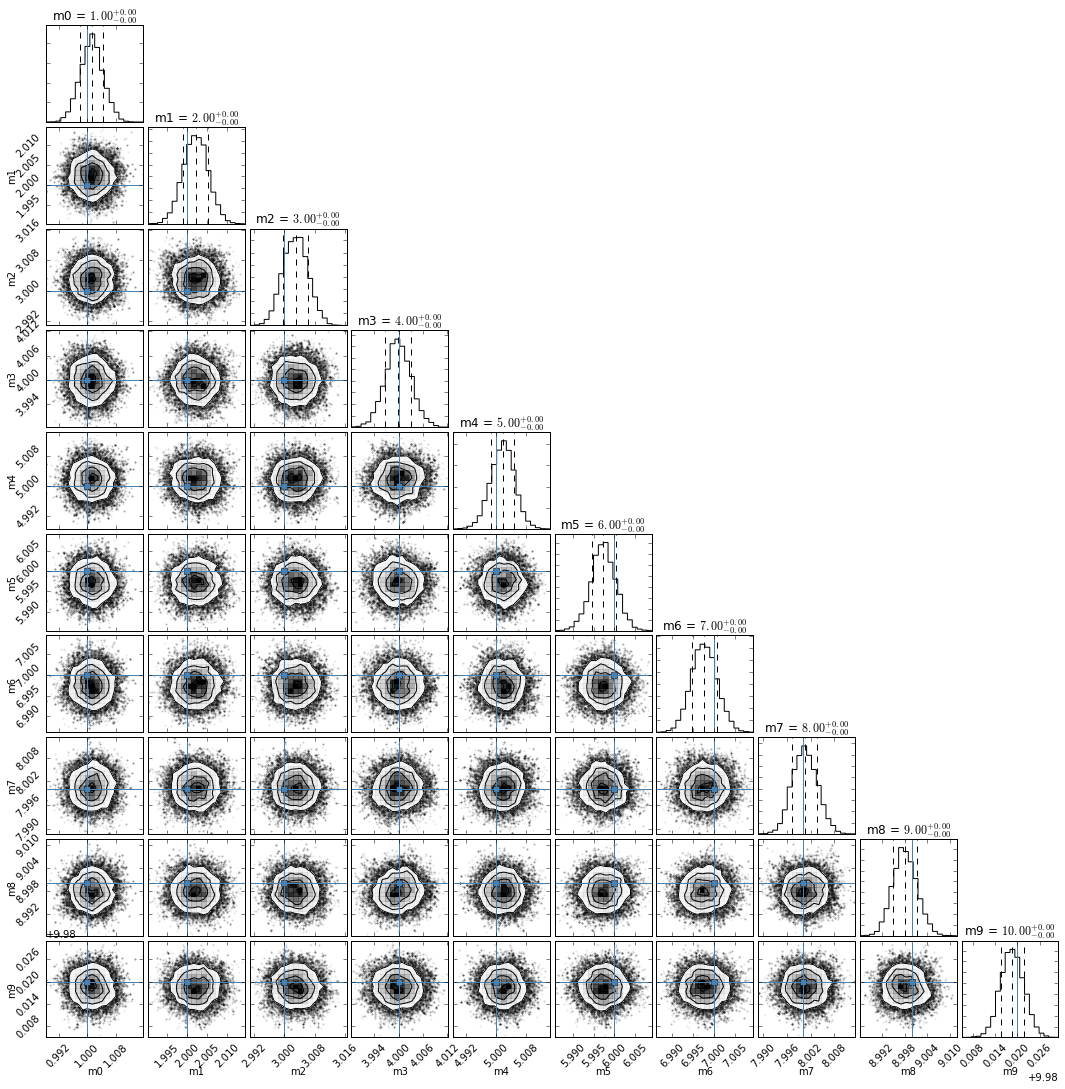

In [9]:

mNd=eknn.alan_eg()
mecNd=make_emcee_chain(mNd,nwalkers=200)
chainNd,fsNd=mecNd.Sampler(nsamples=50000)
print(fsNd.shape)
print(chainNd.shape)
#mec2d.vis()

#let's trangle plot chain samples 
fig = corner.corner(chainNd, labels=mNd.label,
                      truths=mNd.mean, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, labels_args={"fontsize": 40})
fig.set_size_inches(15,15)


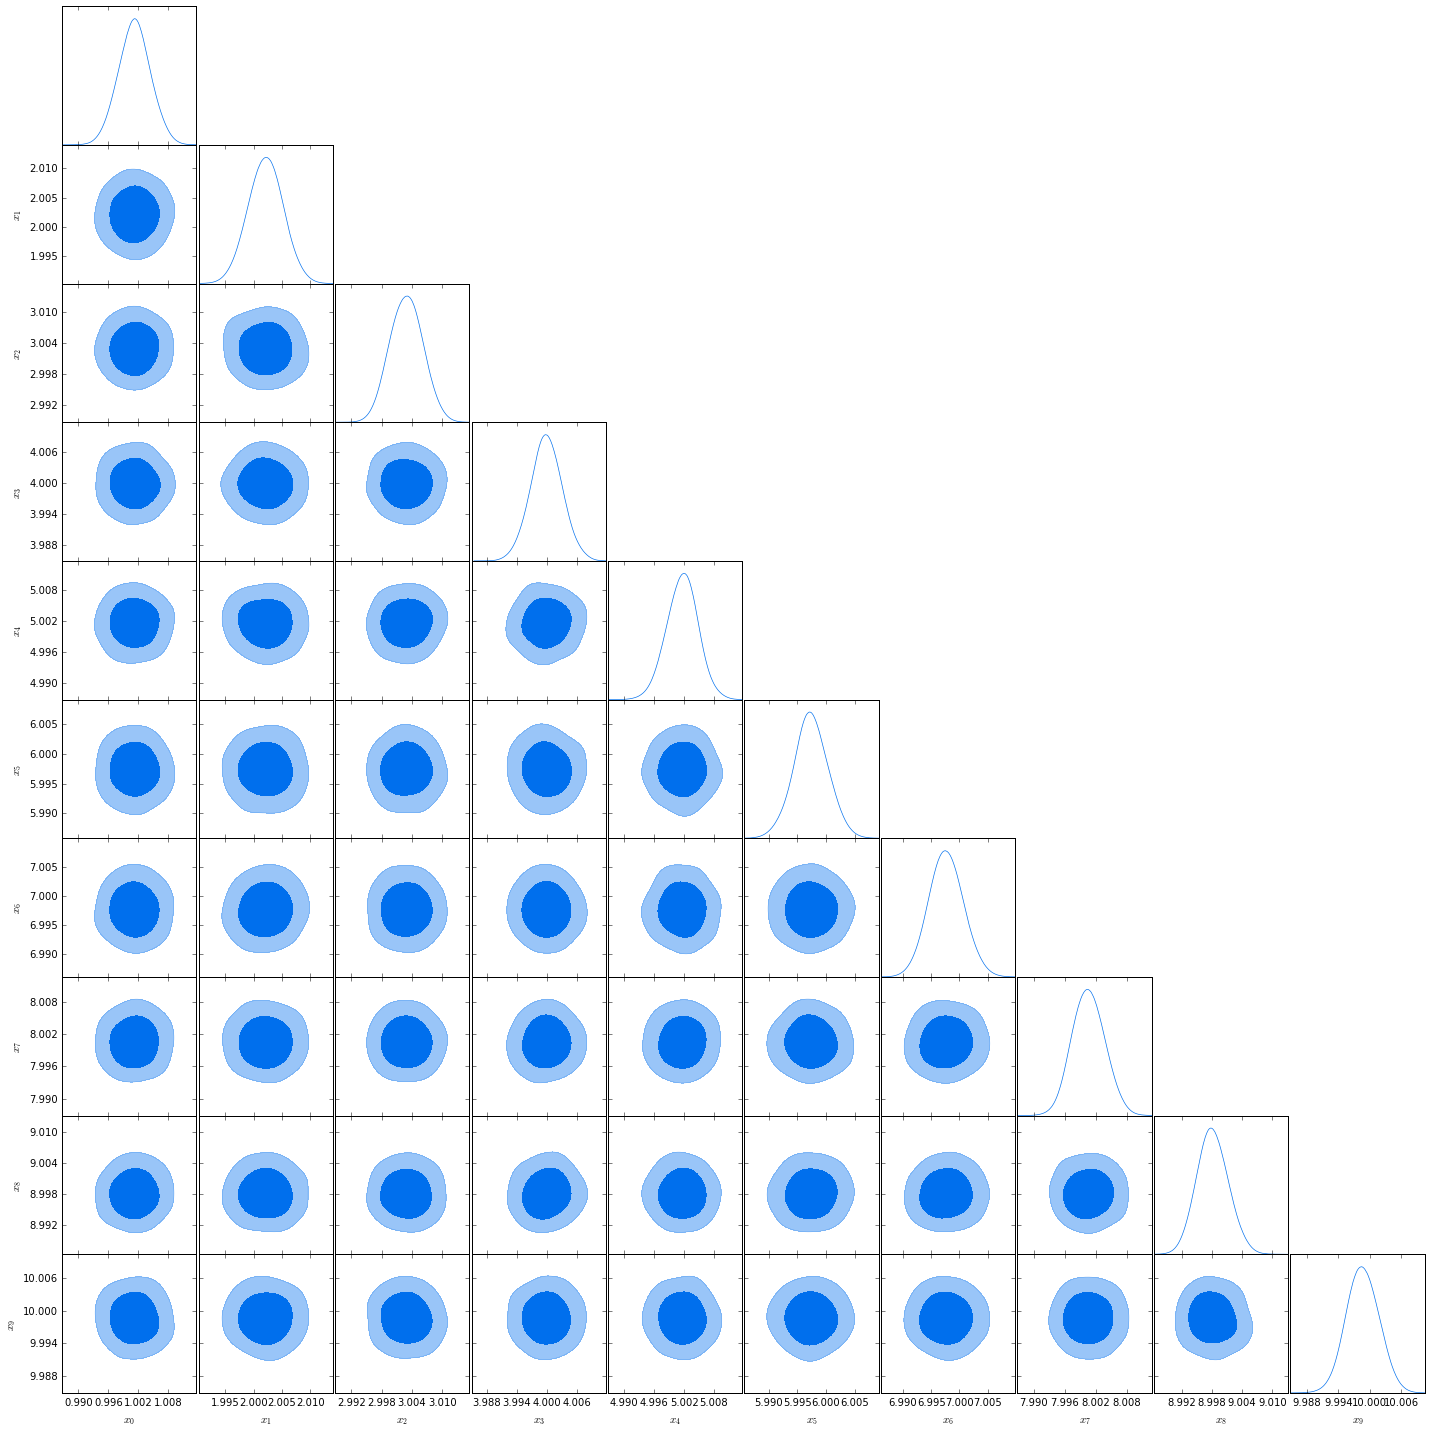

In [48]:
#corner plot can be done also using getdist wrapper
#getdist wrapper has a lot more functionality than just plotting
gd_mc=samples2gdist(chainNd,fsNd)
gd_mc.triangle()

## Gibbs Sampling

# Corner plotting example with fake MCMC samples

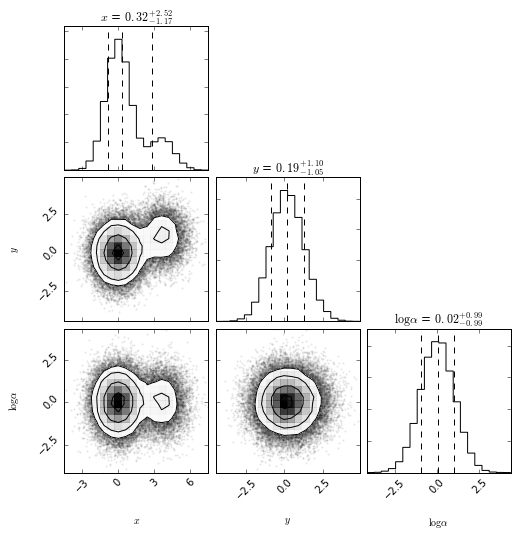

In [31]:
import corner
# Set up the parameters of the problem.
ndim, nsamples = 3, 50000

# Generate some fake data.
np.random.seed(42)
data1 = np.random.randn(ndim * 4 * nsamples // 5).reshape([4 * nsamples // 5, ndim])
data2 = (4*np.random.rand(ndim)[None, :] + np.random.randn(ndim * nsamples // 5).reshape([nsamples // 5, ndim]))
data = np.vstack([data1, data2])

# Plot it.
figure = corner.corner(data, labels=[r"$x$", r"$y$", r"$\log \alpha$", r"$\Gamma \, [\mathrm{parsec}]$"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

'1'